# Polynomial Interpolation Schemes

## Problem

Interpolate the function

$$ f(x) = \frac{1}{1 + x^4} $$

on the interval $ x \in [-5, 5] $, using polynomial interpolation.

## Approach

Aitken-Neville is a recursive scheme for efficient evaluation of an interpolating polynomial $P(t)$ with a given $t$-value. It is not so efficient when evaluating at several $t$-values, or if the polynomial coefficients are wanted. Further below, a more efficient scheme for this purpose will be demonstrated.


## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
def f(x: np.ndarray) -> np.ndarray:
    return 1/(np.power(x, 4) + 1)


def aitken_neville(t: np.ndarray, f: np.ndarray, x, *args) -> np.ndarray:
    """Evaluate the interpolating polynomial at the value of `x0` using
    the Aitken-Neville polynomial interpolation scheme

    Arguments:
    t -- nodes
    f -- values
    x -- point to evaluate the interpolating polynomial at
    *args -- unused
    """
    f = f.copy()
    for k in range(1, len(f)):
        for j in range(len(f)-1, k-1, -1):
            f[j] = f[j] + (x - t[j])/(t[j] - t[j-k])*(f[j] - f[j-1])

    return f[-1]


def div_diffs():
    """This interpolation method will be defined later"""

    pass

In [3]:
def driver(nodes, f, method=aitken_neville):
    """The helper function for comparing interpolation methods

    `method` has a signature of (t, f, x, coeffs)
    """
    values = f(nodes)
    fig, ax = plt.subplots()
    ax.plot(nodes, values, 'o', label='nodes')

    # the interpolating polynomial will be evaluated at 1000 points,
    # but is constructed from the nodes variable
    x = np.linspace(nodes[0], nodes[-1], 1000)
    p = np.zeros_like(x)

    t_0 = time.time()

    coeffs = newton_coeffs(nodes, values) if method == div_diffs else None
    for i in range(len(x)):
        p[i] = method(nodes, values, x[i], coeffs)

    t_end = time.time()
    print(f'Elapsed time: {t_end - t_0} s')

    ax.plot(x, p, label='polynomial interpolation')
    ax.plot(x, f(x), label='exact solution', color='black', linewidth='0.5')
    ax.legend()

    temp_x = 0.5*(nodes[0] + nodes[1])
    end_error = np.abs(f(temp_x) - method(nodes, values, temp_x, coeffs))
    print(f'Absolute error in between two nodes closest to end: {end_error}')

    return fig, ax

Elapsed time: 0.24009156227111816 s
Absolute error in between two nodes closest to end: 17.328559647275636


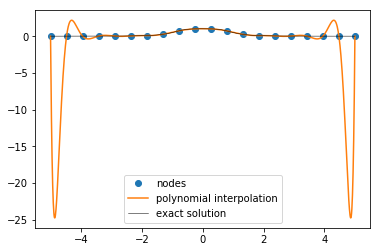

In [4]:
# number of interpolating nodes:
n = 20
xmin = -5
xmax = 5
nodes = np.linspace(xmin, xmax, n)

fig, ax = driver(nodes, f)

With a degree 20 interpolating polynomial, the interpolation error at the ends of the interval becomes large. This is to be expected with equally-spaced nodes. Zooming in and overlaying the original exact function, it appears that the interpolation in the center of the interval is quite good.

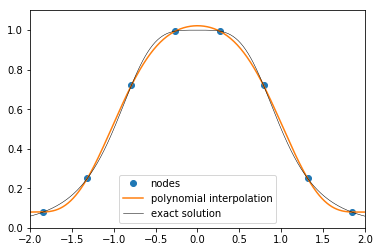

In [5]:
ax.set_xlim((-2, 2))
ax.set_ylim((0, 1.1))

fig

Repeating the interpolation for a higher amount of interpolation nodes results in an even worse approximation at the ends of the interval:

Elapsed time: 5.314611196517944 s
Absolute error in between two nodes closest to end: 9.849991305981853e+16


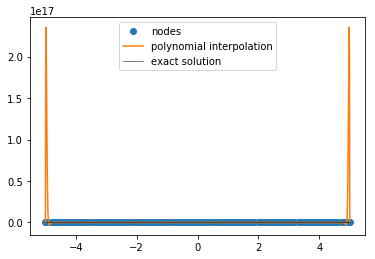

In [6]:
n = 100
nodes = np.linspace(xmin, xmax, n)
fig, ax = driver(nodes, f)

To help alleviate this problem, Chebyshev nodes can be used instead of equally spaced nodes. The Chebyshev nodes are equivalent to the $x$-coordinates of $n$ equally spaced points on a unit semicircle, and are defined on the interval $[-1, 1]$ by
$$x_k = \cos\left(\frac{2k-1}{2n}\pi\right), \quad k = 1, \ldots, n. $$

With an affine transformation, an arbitrary interval can be used:

$$ x_k = \frac{1}{2} (a + b) + \frac{1}{2} (b - a) \cos\left(\frac{2k-1}{2n}\pi\right), \quad k = 1, \ldots, n. $$

In [7]:
def chebyshevspace(a, b, n):
    k = np.arange(1, n+1)
    return 0.5*((b + a) + (b - a)*np.cos((2*k - 1)/(2*n)*np.pi))

Elapsed time: 1.2791781425476074 s
Absolute error in between two nodes closest to end: 4.2710891173606755e-05


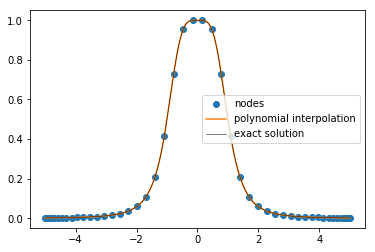

In [8]:
n = 50
nodes = chebyshevspace(xmin, xmax, n)
fig, ax = driver(nodes, f)

Newton's interpolation formula using divided differences is well-suited for evaluating an interpolating polynomial at several $t$-values, or if the polynomial coefficients are wanted. With this method, the computational time is reduced.

In [9]:
def newton_coeffs(t: np.ndarray, f: np.ndarray) -> np.ndarray:
    """Compute the Newton polynomial coefficients

    Arguments:
    t -- nodes
    f -- values
    """
    n = len(t)
    coeffs = np.copy(f)
    for i in range(1, n):
        coeffs[i:n] = (coeffs[i:n] - coeffs[i-1])/(t[i:n] - t[i-1])

    return coeffs


def div_diffs(t: np.ndarray, f: np.ndarray, x, coeffs=None) -> np.ndarray:
    """Compute the polynomial value using Newton's divided differences scheme

    Arguments:
    t -- nodes
    f -- values
    x -- interpolation points
    coeff -- Newton polynomial coefficients to use
             (default behavior: calculate if not specified)
    """
    if coeffs is None:
        coeffs = newton_coeffs(t, f)

    # Horner's scheme with degree n:
    n = len(coeffs) - 1
    res = coeffs[-1]
    for i in range(n-1, -1, -1):
        res = res*(x - t[i]) + coeffs[i]
    return res

Elapsed time: 0.03322911262512207 s
Absolute error in between two nodes closest to end: 3.212062311455351e-05


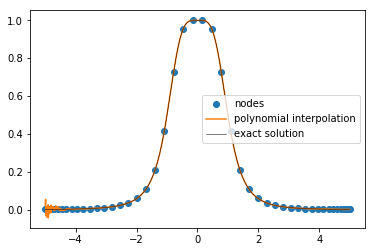

In [10]:
fig, ax = driver(nodes, f, method=div_diffs)